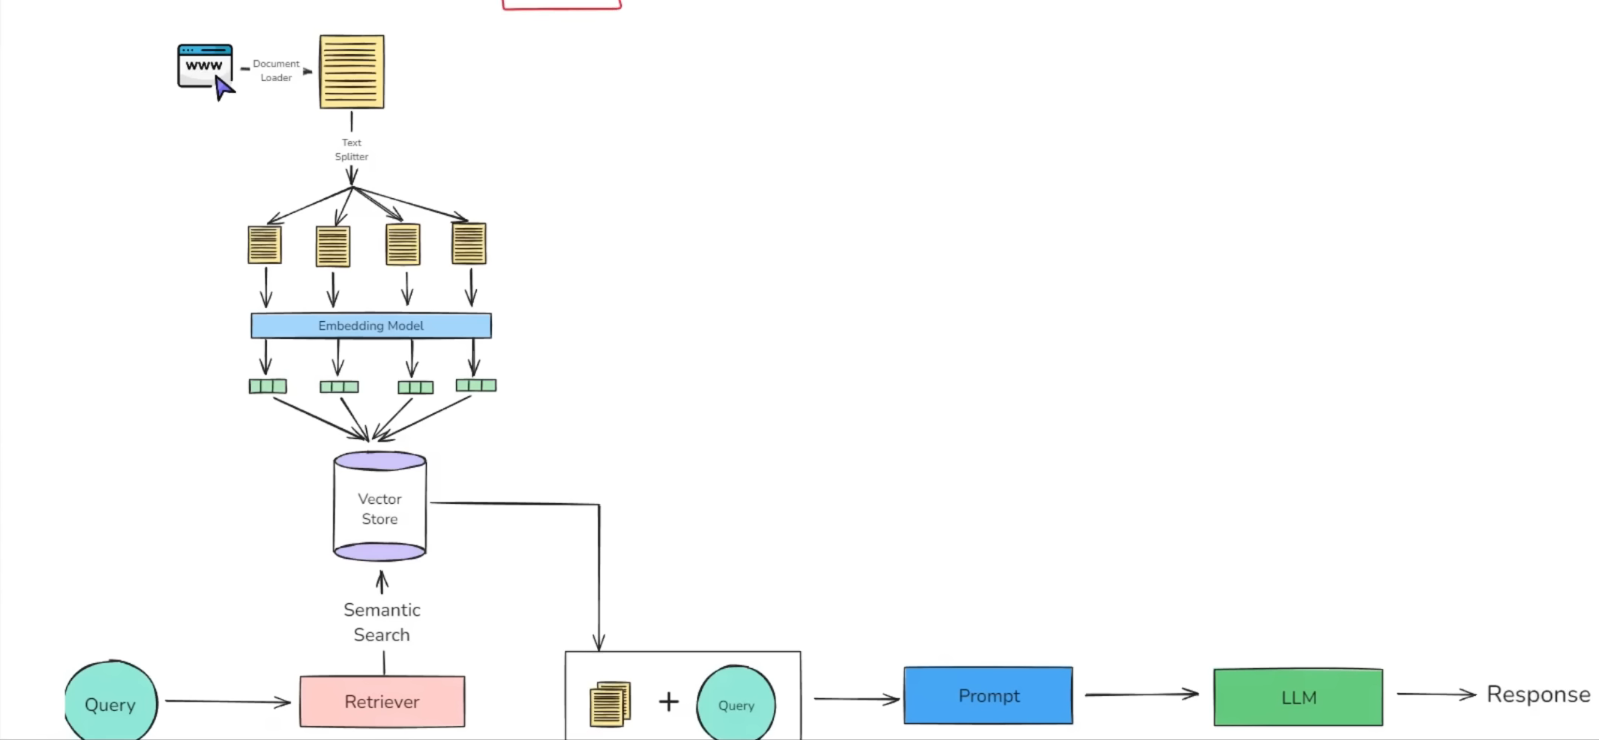



## Summary of Building a YouTube Chatbot RAG System

The video continues the discussion on RAG (Retrieval Augmented Generation) by focusing on the practical application of building a RAG-based system using LangChain. This system is designed to allow users to **chat with any YouTube video in real-time**.

### I. The Problem Statement: YouTube Chatbot

The goal is to solve the problem where users must watch an entire video, especially long ones like three-hour podcasts, to understand the content. The solution is a RAG-based chat system that allows users to query the video content, such as asking if AI was discussed, requesting a five-bullet-point summary, or resolving doubts in a lecture.

**Interface Options (For context, though not the focus of the current implementation):**
The final product could be a Chrome plugin with a chat interface that opens while the video plays, or a Streamlit website where the user pastes the video link to open a new chat window. The current implementation focuses on the core RAG functionality within a Google Colab notebook, deferring UI development.

### II. RAG Architecture and Implementation Flow

The project utilizes the standard RAG architecture discussed in previous videos, which involves four main steps: Indexing, Retrieval, Augmentation, and Generation.

#### Step 1: Indexing (Building the Knowledge Base)

Indexing prepares the video content for efficient retrieval.

1.  **Document Loading (Fetching the Transcript):** The first goal is to load the YouTube video's transcript, which contains everything spoken in the video, recorded sentence by sentence.
    *   While LangChain has a `YTLoader` (YouTube Loader) Document Loader, the project uses **YouTube's own API** due to reported bugginess of the LangChain loader with certain videos.
    *   The video ID is extracted from the URL and used to fetch the transcript, which initially returns a list of dictionaries with time stamps, text, and duration.
    *   **Transcript Processing:** Since the retrieved transcript contains time-stamped, broken-up sentences, the code runs a loop to **join** all these sentences, creating one large, contiguous string representing the complete video transcript. The transcript language can be specified (e.g., English or Hindi).
2.  **Text Splitting (Chunking):** Since the complete transcript (especially for a two-hour video) is very long, it must be divided into smaller, manageable chunks.
    *   The **Recursive Character Text Splitter** is used for this task.
    *   Parameters used in the example are a `chunk_size` of 1000 or 1200 and a `chunk_overlap` of 200, resulting in 168 chunks in the example.
3.  **Embedding and Storage:** The chunks are converted into vectors and stored.
    *   An **Embedding Model** (specifically, the OpenAI Embeddings model) is chosen.
    *   The vectors and their corresponding text chunks are stored in the **FAISS Vector Store** (which is chosen for this basic system).

#### Step 2: Retrieval

This step involves finding the relevant documents that can answer the user's query.

1.  **Retriever Creation:** A simple **Similarity Search-based Retriever** is created using the existing FAISS Vector Store.
2.  **Search Execution:** The retriever is configured to find the top four most similar documents (`k=4`). When a query (e.g., "What is DeepMind?") is sent, the retriever embeds the query, performs a semantic search in the vector store, and returns a list of the four most relevant text chunks (documents). The input is a query, and the output is a list of documents.

#### Step 3: Augmentation

The relevant chunks and the user's query are merged into a final prompt for the LLM.

1.  **Prompt Template Design:** A simple `PromptTemplate` is created with instructions for the LLM: **"You are a helpful assistant. Answer ONLY from the provided transcript context. If the context is insufficient, just say you don't know."**.
2.  **Input Variables:** The template has two input variables: `context` and `question`.
3.  **Context Concatenation:** Since the retriever returns multiple separate documents (chunks), the `page_content` of all retrieved documents must be concatenated into one large string to serve as the single `context` input for the prompt.
4.  **Final Prompt Assembly:** The question and the large context string are used to invoke the prompt template, creating the **Final Prompt**.

#### Step 4: Generation

The augmented prompt is sent to the LLM to generate the final answer.

1.  **LLM Invocation:** An LLM (OpenAI's model is used in the example) is invoked with the Final Prompt.
2.  **Response:** The LLM uses the provided context to generate a grounded response, which can then be stripped of metadata to provide just the answer content.

### III. Orchestration using LangChain Chains

The initial step-by-step process requires manual calls for retrieval, prompting, and generation, which is inefficient. The solution is to convert the entire RAG pipeline into a single **LangChain Chain** using **Runnables** and the **LangChain Expression Language (LCEL)**.

**Chain Structure:** The RAG pipeline is converted into two interconnected chains:

1.  **Parallel Chain (Data Preparation):** This chain handles the steps required to gather both the `context` and the `question`.
    *   It is built using `RunnableParallel`.
    *   **Context Branch:** This branch takes the user's question, sends it to the `Retriever` to get documents, and then uses a custom Python function (`format_docs`) wrapped in `RunnableLambda` to concatenate those documents into a single context string.
    *   **Question Branch:** This simple branch uses `RunnablePassThrough` to take the input question and pass it directly through as the output question.
    *   **Output:** The Parallel Chain outputs a dictionary containing the `context` (large string) and the `question`.
2.  **Main Chain (Augmentation and Generation):** This chain is responsible for generating the final response.
    *   It is a sequential chain composed of the `Prompt` template, the `LLM`, and a `StringOutputParser`.
    *   **Connection:** The output dictionary from the Parallel Chain (containing context and question) is fed directly into the Prompt, fulfilling its required inputs.
    *   The main chain is connected declaratively (using the pipe operator) as: `ParallelChain | Prompt | LLM | Parser`.
    *   **Final Result:** A single call to `main_chain.invoke(question)` automatically executes the entire pipeline (retrieval, augmentation, and generation), simplifying the code flow.

### IV. Suggestions for Advanced and Industry-Grade RAG Systems

The source notes that the current RAG system is a basic example and suggests numerous ways to improve it for complex, production-level use cases, which form the basis of a field called **Advanced RAG**. These improvements are categorized across the RAG steps:

#### A. UI-Based Enhancements
*   Build a **Streamlit website** where the user inputs the video URL.
*   Create a **Chrome plugin** that activates when a YouTube video is open, allowing in-video chat.

#### B. Evaluation
*   Use evaluation strategies and libraries like **Ragas** to assess system performance.
*   Ragas measures metrics like **Faithfulness** (answer related to context), **Answer Relevancy** (answer related to question), **Context Precision** (usefulness of retrieved context), and **Context Recall** (retrieval of useful info from vector store).
*   Use tracing tools like **LangSmith** to check the pipeline's execution at every step.

#### C. Indexing Improvements
*   **Document Ingestion:** Fix errors in auto-generated transcripts (e.g., from YouTube) or translate transcripts from other languages (like Hindi) into English.
*   **Text Splitting:** Use **Semantic Chunker** instead of Recursive Character Text Splitter to ensure chunks maintain semantic meaning and avoid breaking context mid-paragraph.
*   **Vector Store:** For enterprise solutions, use production-grade, cloud-based vector stores like **Pinecone** instead of basic local solutions like FAISS.

#### D. Retrieval Optimizations
*   **Pre-Retrieval:**
    *   Use an LLM to **rewrite/improve a vague user query** before searching.
    *   Employ a **Multi-Query Retriever** to generate multiple perspectives of an ambiguous query to improve the search.
    *   Implement **Domain-Aware Routing** to trigger specific retrievers for different types of queries in complex systems.
*   **During Retrieval:**
    *   Use search strategies like **MMR (Maximum Marginal Relevance)** to retrieve results that are both relevant and diverse, reducing redundancy.
    *   Implement **Hybrid Retrieval** (combining semantic search with keyword search).
    *   Use an LLM to perform **Re-ranking** of retrieved documents based on relevance before moving to the next stage.
*   **Post-Retrieval:**
    *   Utilize **Contextual Compression** to trim non-meaningful text from retrieved documents, ensuring only the most useful information is passed to the prompt.

#### E. Augmentation Improvements
*   **Prompt Templating:** Refine prompt design to better explain the context and the question to the LLM, potentially using examples.
*   **Answer Grounding:** Explicitly instruct the LLM to **only answer using the context** and avoid hallucinating facts.
*   **Context Window Optimization:** Ensure that the total size of the prompt (context plus question) does not exceed the LLM's token limits by trimming the context if necessary.

#### F. Generation Improvements and System Types
*   **Answer with Citation:** Instruct the LLM to specify which part of the context was used to generate each part of the answer.
*   **Guard Railing:** Implement mechanisms to prevent the LLM from generating inappropriate or incorrect outputs.
*   **Advanced RAG Systems:**
    *   **Multimodal RAG:** Design systems that can process and retrieve information from text, images, and videos, not just text.
    *   **Agentic RAG:** Build an AI Agent that can perform actions (like web browsing) in addition to answering questions, allowing it to retrieve current or external information and merge it with the RAG context.
    *   **Memory-Based RAG:** Create personalized RAG systems that maintain conversation history over time, allowing the system to reference previous interactions when answering new queries.

The entire RAG system for the YouTube Chatbot is built sequentially using LangChain components. Below is a summary of the implementation steps, structured as code blocks suitable for a Google Colab notebook, drawing directly from the procedures outlined in the sources.

```python
# =======================================================
# I. SETUP AND INDEXING (Building the Knowledge Base)
# =======================================================

# 1. API Key Setup
# Use OpenAI models for embeddings and generation.
OPENAI_API_KEY = "YOUR_TRIMMED_KEY" # Ensure to replace with your actual key

# 2. Document Loading (Fetching and Preprocessing Transcript)

# The implementation uses YouTube's internal API because LangChain's YTLoader
# was found to be buggy with some videos.

VIDEO_ID = "Your_Video_ID_from_URL" # Only the ID, not the full URL
TRANSCRIPT_LANGUAGE = "English" # Can be set to "Hindi" if English is unavailable

# Internal code runs the YouTube Transcript API's get_transcript function.
# The raw transcript is a list of dictionaries, time-stamped and sentence-by-sentence.
RAW_TRANSCRIPT = get_transcript(video_id=VIDEO_ID, languages=[TRANSCRIPT_LANGUAGE])

# Concatenate the broken-up sentences into one large string.
COMPLETE_TRANSCRIPT_STRING = "".join([item['text'] for item in RAW_TRANSCRIPT])
# This string is the input document for the next step.

# 3. Text Splitting (Chunking)

# Use Recursive Character Text Splitter to handle the long transcript.
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200, # Example chunk size used in the source
    chunk_overlap=200 # Example overlap used in the source
)

CHUNKS = text_splitter.create_documents([COMPLETE_TRANSCRIPT_STRING])
# The example yielded 168 chunks.

# 4. Embedding and Vector Storage
# Convert chunks to vectors and store them for semantic search.

from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

# Choose the embedding model.
EMBEDDING_MODEL = OpenAIEmbeddings()

# Use FAISS Vector Store, a basic level store, for the project.
VECTOR_STORE = FAISS.from_documents(CHUNKS, EMBEDDING_MODEL)

# =======================================================
# II. RETRIEVAL (Finding Context)
# =======================================================

# 1. Retriever Creation
# Create a simple similarity search-based retriever from the Vector Store.
RETRIEVER = VECTOR_STORE.as_retriever(search_type="similarity", k=4)
# Configured to find the top four most similar documents.

# Example Retrieval (Manual Test)
QUERY = "What is DeepMind?" # Example query
RETRIEVED_DOCUMENTS = RETRIEVER.invoke(QUERY)
# Output: A list of four relevant Document objects.

# =======================================================
# III. AUGMENTATION AND GENERATION (Manual Execution)
# =======================================================

from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI

# 1. LLM Initialization and Prompt Template Design
LLM = ChatOpenAI() # LLM formed for the generation stage

# Define the prompt template with instructions for Answer Grounding.
PROMPT_TEMPLATE = """
You are a helpful assistant. Answer ONLY from the provided transcript context.
If the context is insufficient, just say you don't know.

Context: {context}
Question: {question}
"""

PROMPT = PromptTemplate(
    template=PROMPT_TEMPLATE,
    input_variables=["context", "question"] # Requires two inputs
)

# 2. Context Merging (Augmentation)
# A custom step is required to concatenate the document contents.
def concatenate_docs(retrieved_documents):
    # Iterate through documents and join their page_content into one large string.
    CONTEXT_STRING = "\n\n".join(doc.page_content for doc in retrieved_documents)
    return CONTEXT_STRING

# 3. Generation (Manual Invocation)
CONTEXT = concatenate_docs(RETRIEVED_DOCUMENTS) # Creates the large context string
FINAL_PROMPT = PROMPT.invoke({"context": CONTEXT, "question": QUERY})

# Answer generation.
RESPONSE = LLM.invoke(FINAL_PROMPT)
FINAL_ANSWER = RESPONSE.content # Extracting only the content string

# =======================================================
# IV. ORCHESTRATION using LCEL (Building the Chain)
# =======================================================

# This step simplifies the manual process by automating the pipeline.

from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableParallel, RunnablePassThrough, RunnableLambda

# Helper function definition for context formatting (same as concatenate_docs).
def format_docs(retrieved_documents):
    return "\n\n".join(doc.page_content for doc in retrieved_documents)

# 1. Parallel Chain (Data Preparation)
# Gathers required inputs (context and question) for the prompt.
PARALLEL_CHAIN = RunnableParallel(
    # Context Branch: Query -> Retriever -> Format Docs (Lambda)
    context=(RETRIEVER | RunnableLambda(format_docs)),
    # Question Branch: Input -> PassThrough
    question=RunnablePassThrough()
)

# 2. Main Sequential Chain (Full RAG Pipeline)
# Connects data preparation to augmentation and generation.
OUTPUT_PARSER = StrOutputParser() # To get the output as a simple string

MAIN_CHAIN = PARALLEL_CHAIN | PROMPT | LLM | OUTPUT_PARSER

# Final Execution
QUESTION = "Can you summarize the video?" # Example query
FINAL_RESULT = MAIN_CHAIN.invoke(QUESTION) # Single call triggers entire workflow

# The FINAL_RESULT contains the complete answer generated by the RAG system.
```

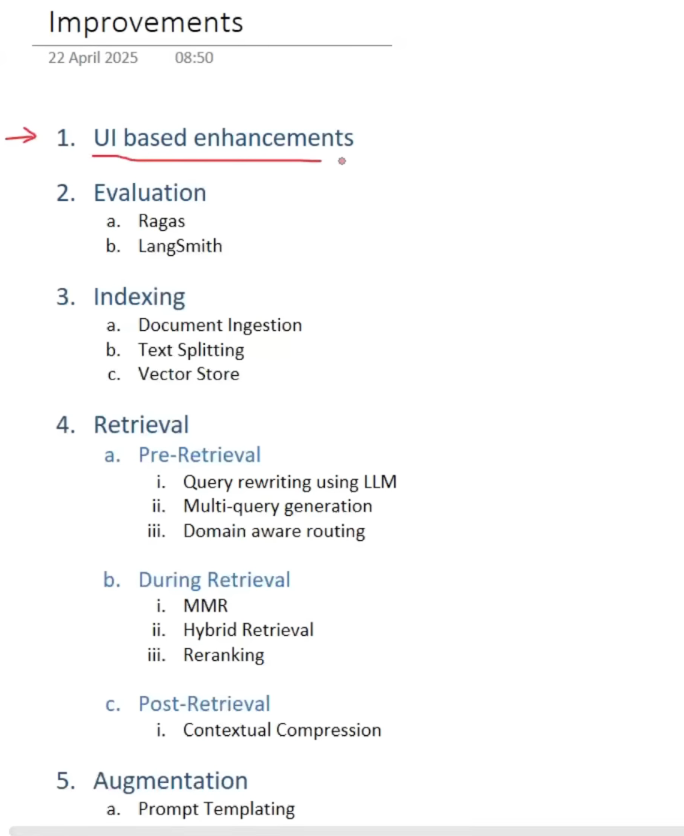

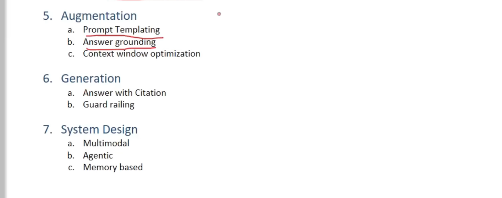